In [ ]:
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch.optim import lr_scheduler as lrs
import torchvision as tv
from torchvision.models import resnet18


from collections import defaultdict

from IPython.display import clear_output
%matplotlib inline

In [ ]:
data_dir = '/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset'
data_images_path = glob.glob(f'{data_dir}/*/*.jpg')
data_image_labels = [path.split('/')[-2] for path in data_images_path]
train_files_path, test_files_path = train_test_split(
    data_images_path,
    test_size = 0.3,
    stratify=data_image_labels
)

print(f'Train len: {len(train_files_path)}\nTest len: {len(test_files_path)}')

Train len: 14653
Test len: 6280


In [ ]:
input_size = 224

train_transform = tv.transforms.Compose([
    tv.transforms.Resize(input_size),
    tv.transforms.CenterCrop(input_size),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(5),
    tv.transforms.ColorJitter(0.8, 0.8, 0.8),
    tv.transforms.ToTensor()
])


test_transform = tv.transforms.Compose([
    tv.transforms.Resize(input_size),
    tv.transforms.CenterCrop(input_size),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

test_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=test_transform,
    is_valid_file=lambda x: x in test_files_path
)

In [ ]:
len(test_dataset.classes), len(train_dataset.classes)

(42, 42)

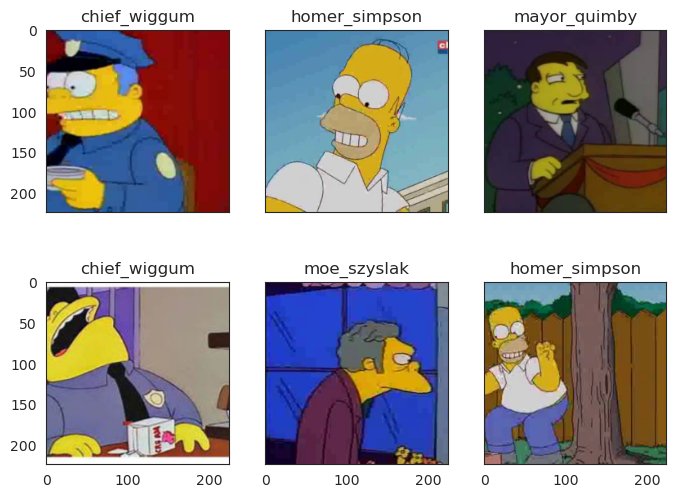

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))
        
show_images(test_dataset)

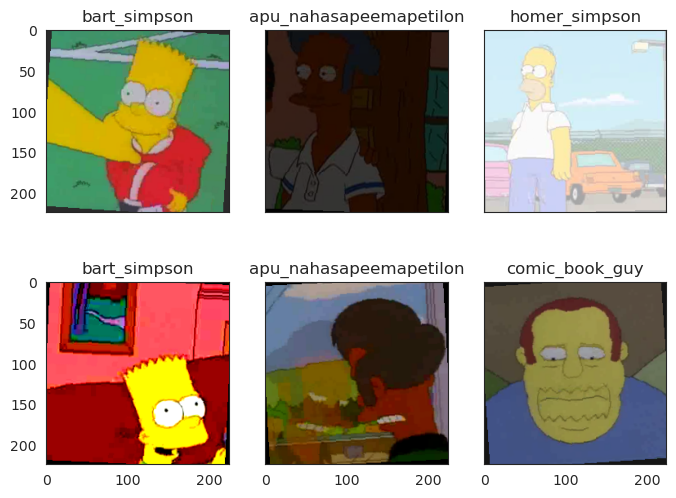

In [ ]:
show_images(train_dataset)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
train_ds = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True
)

test_ds = torch.utils.data.DataLoader(
    test_dataset, batch_size=256, shuffle=False
)

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''
    scheduler = lrs.ReduceLROnPlateau(optimizer, 'min')

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
        scheduler.step(loss)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

## ResNet18 & ReduceLROnPlateau

Epoch 10 of 10 took 146.093s
  training loss (in-iteration): 	1.982406
  validation loss (in-iteration): 	1.884832
  training accuracy: 			54.30 %
  validation accuracy: 			58.63 %


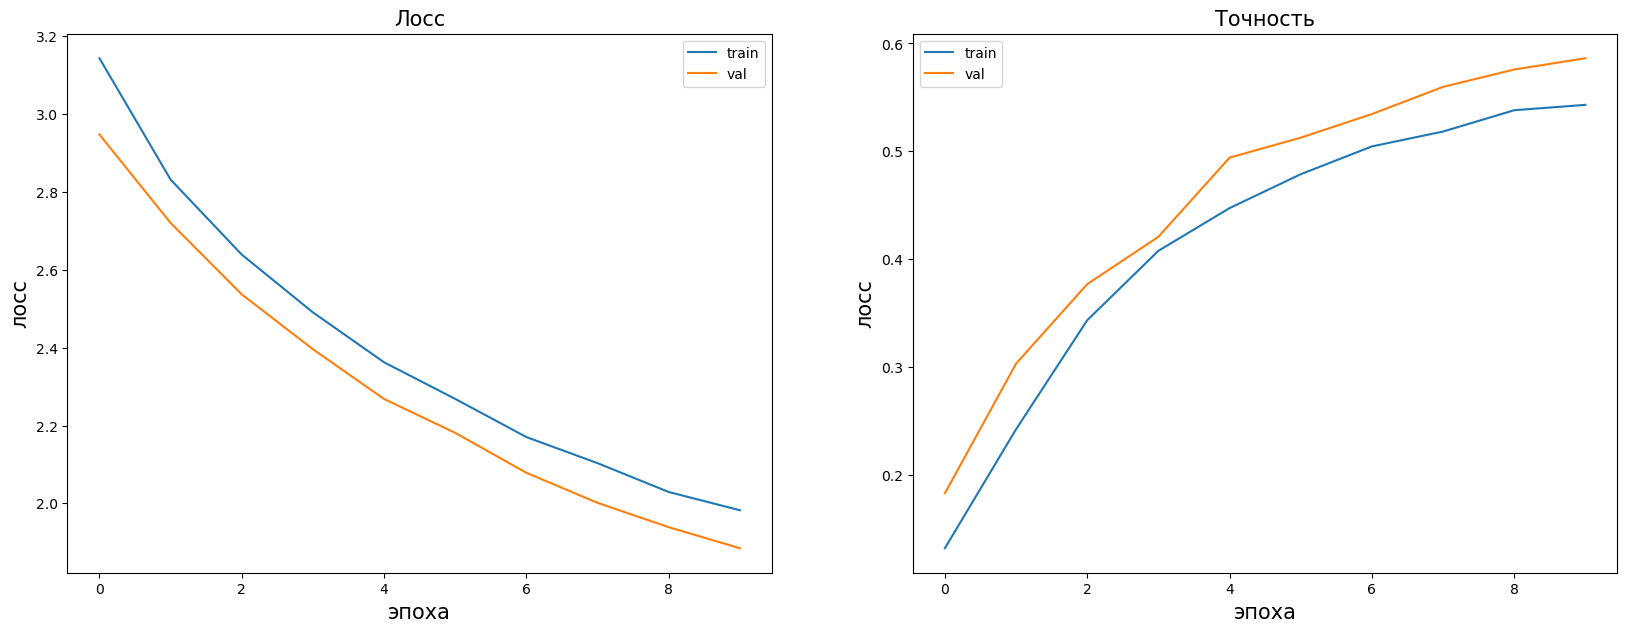

In [ ]:
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = torch.nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer, 
    train_ds, test_ds, 
    num_epochs=10
)

## ResNet18 & ReduceLROnPlateau Finetuning

Epoch 10 of 10 took 196.026s
  training loss (in-iteration): 	0.411200
  validation loss (in-iteration): 	0.419843
  training accuracy: 			89.80 %
  validation accuracy: 			89.40 %


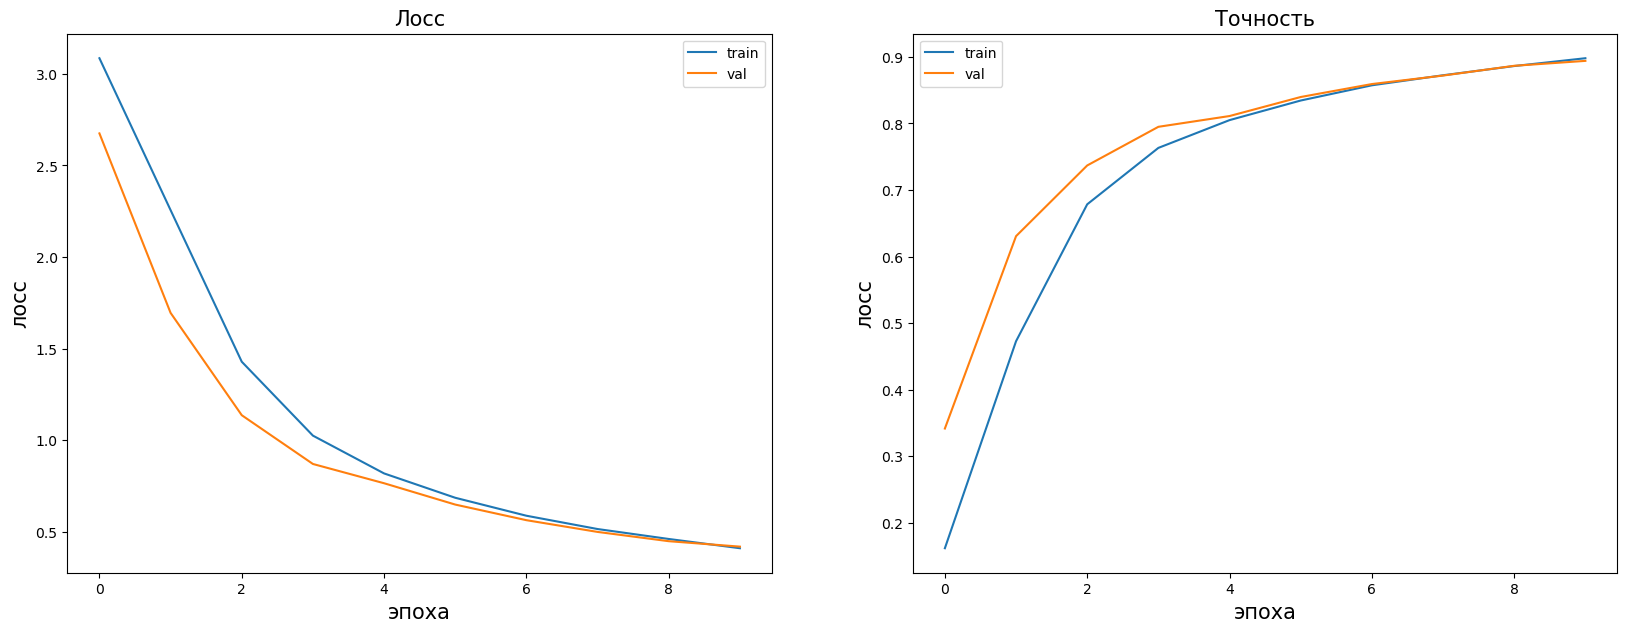

In [ ]:
fine_tuning_model = torch.nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', torch.nn.ReLU())
fine_tuning_model.add_module('fc_1', torch.nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', torch.nn.ReLU())
fine_tuning_model.add_module('fc_2', torch.nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_ds, test_ds, 
    num_epochs=10
)

## StepLR

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''
    scheduler = lrs.StepLR(optimizer, step_size=3)

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
        scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Epoch 10 of 10 took 179.736s
  training loss (in-iteration): 	1.064120
  validation loss (in-iteration): 	1.047640
  training accuracy: 			76.23 %
  validation accuracy: 			75.97 %


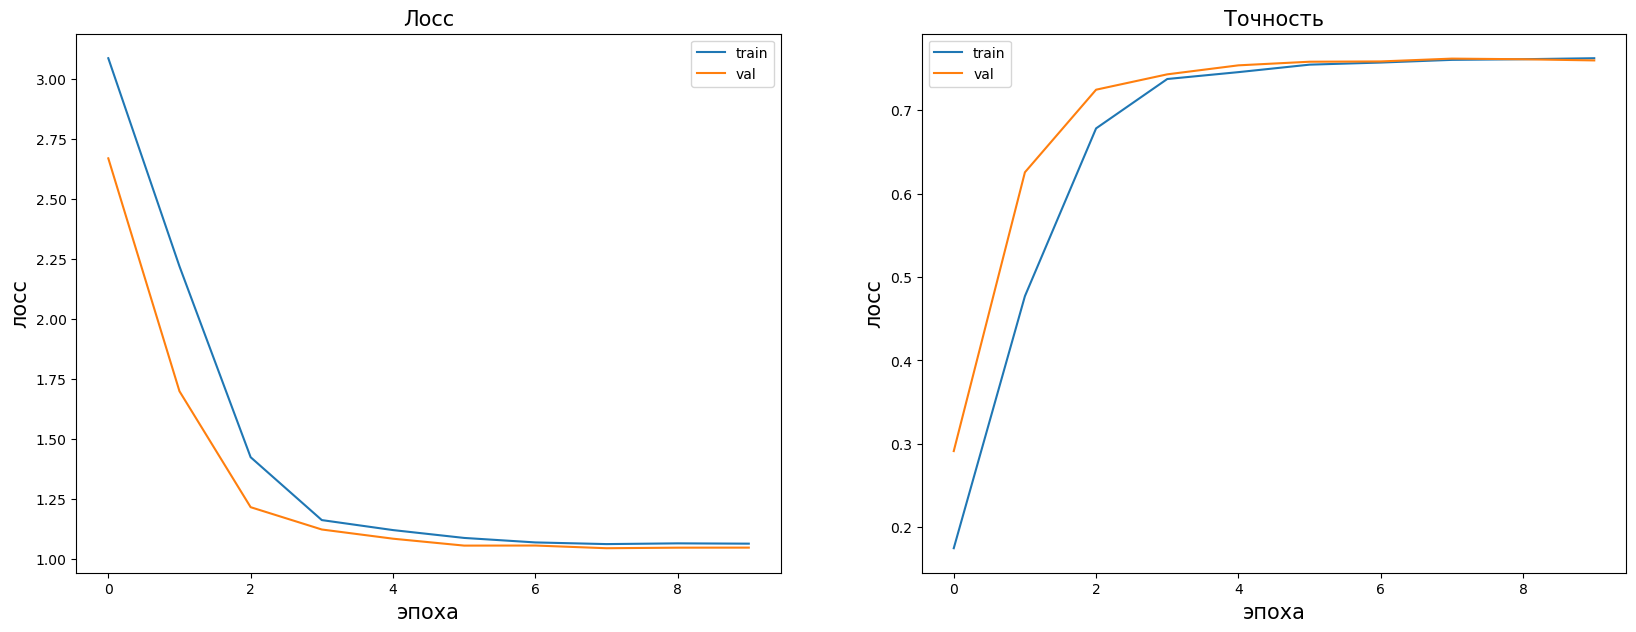

In [ ]:
fine_tuning_model = torch.nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', torch.nn.ReLU())
fine_tuning_model.add_module('fc_1', torch.nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', torch.nn.ReLU())
fine_tuning_model.add_module('fc_2', torch.nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_ds, test_ds, 
    num_epochs=10
)

StepLr показал себя хуже чем ReduceLROnPlateau